In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import OrderedDict

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
model = nn.Sequential(OrderedDict([
    ('encoder', nn.Linear(3, 2)),
    ('decoder', nn.Linear(2, 3))
]))

model

Sequential(
  (encoder): Linear(in_features=3, out_features=2, bias=True)
  (decoder): Linear(in_features=2, out_features=3, bias=True)
)

In [59]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

In [60]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [61]:
# Convert X_train to a PyTorch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)

In [62]:
n_epochs = 500

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

encoded_data = model.encoder(X_train)
print(f"Encoded 2D data:\n{encoded_data}")

Epoch [50/500], Loss: 0.0587
Epoch [100/500], Loss: 0.0264
Epoch [150/500], Loss: 0.0236
Epoch [200/500], Loss: 0.0235
Epoch [250/500], Loss: 0.0234
Epoch [300/500], Loss: 0.0234
Epoch [350/500], Loss: 0.0233
Epoch [400/500], Loss: 0.0233
Epoch [450/500], Loss: 0.0233
Epoch [500/500], Loss: 0.0233
Encoded 2D data:
tensor([[-0.7318,  0.7975],
        [ 0.0206, -0.1009],
        [ 1.5800,  0.5812],
        [ 0.5647,  0.4566],
        [-0.6911,  0.5186],
        [-0.1545,  0.5101],
        [-0.6843,  0.7422],
        [ 1.4101, -0.2182],
        [ 0.6698,  0.9164],
        [ 1.7627,  0.5047],
        [-1.3187,  0.2753],
        [-0.5276,  0.1607],
        [ 1.2819, -0.1601],
        [-0.5463,  0.6708],
        [-0.2487,  0.3121],
        [-0.3352,  0.3606],
        [-0.6110,  0.6013],
        [-0.4025,  0.6941],
        [-0.2546,  0.7026],
        [-0.5377,  0.5933],
        [ 0.5020,  0.6277],
        [-0.4572,  0.3385],
        [-0.9954,  0.5469],
        [ 0.3450,  0.5006],
        [-0.

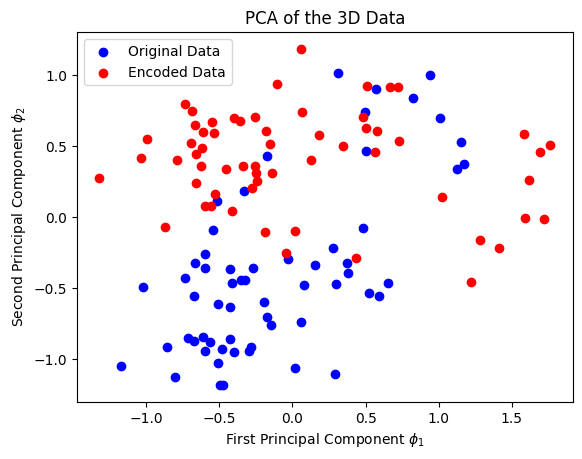

In [63]:
import matplotlib.pyplot as plt

z = encoded_data.detach().numpy()

plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Original Data')
plt.scatter(z[:, 0], z[:, 1], c='red', label='Encoded Data')
plt.xlabel(r'First Principal Component $\phi_1$')
plt.ylabel(r'Second Principal Component $\phi_2$')
plt.title('PCA of the 3D Data')
plt.legend()
plt.show()

In [64]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Download and load the MNIST dataset
print("Downloading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32') / 255.0
y = y.astype('int64')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
X_test_tensor = torch.from_numpy(X_test)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"MNIST dataset loaded. Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

# Get a batch of images for training
X_train, mean = next(iter(train_loader))
print(f"Shape of a batch: {X_train.shape}")

# Get a batch of images for validation
X_valid, mean = next(iter(test_loader))

# Reshape the data to match the expected input shape of the model
X_train = X_train.view(-1, 28, 28)
X_valid = X_valid.view(-1, 28, 28)
# Reshape the test data to match the expected input shape of the model
X_test = X_test_tensor.view(-1, 28, 28)


print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of X_valid: {X_valid.shape}")


MNIST dataset loaded. Train size: 56000, Test size: 14000
Shape of a batch: torch.Size([64, 784])
Final shape of X_train: torch.Size([64, 28, 28])
Final shape of X_valid: torch.Size([64, 28, 28])


In [65]:
class StackedAutoencoder(nn.Module):
    def __init__(self):
        super(StackedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 100),  # Input size: 28x28 flattened to 784
            nn.ReLU(),
            nn.Linear(100, 30),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),
            nn.Linear(100, 28 * 28),  # Output size: 784 (28x28)
            nn.Unflatten(1, (28, 28))  # Reshape back to 28x28
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = StackedAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:  # Assuming train_loader is defined
        optimizer.zero_grad()
        x = batch[0].view(-1, 28, 28)  # Reshape to match model input
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid)
        val_loss = criterion(val_outputs, X_valid)
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}, Validation Loss: {val_loss.item():.4f}')


Epoch [1/30], Loss: 0.0326, Validation Loss: 0.0241
Epoch [2/30], Loss: 0.0227, Validation Loss: 0.0238
Epoch [3/30], Loss: 0.0216, Validation Loss: 0.0220
Epoch [4/30], Loss: 0.0210, Validation Loss: 0.0211
Epoch [5/30], Loss: 0.0204, Validation Loss: 0.0208
Epoch [6/30], Loss: 0.0199, Validation Loss: 0.0202
Epoch [7/30], Loss: 0.0194, Validation Loss: 0.0195
Epoch [8/30], Loss: 0.0189, Validation Loss: 0.0191
Epoch [9/30], Loss: 0.0184, Validation Loss: 0.0185
Epoch [10/30], Loss: 0.0180, Validation Loss: 0.0183
Epoch [11/30], Loss: 0.0176, Validation Loss: 0.0180
Epoch [12/30], Loss: 0.0173, Validation Loss: 0.0176
Epoch [13/30], Loss: 0.0170, Validation Loss: 0.0173
Epoch [14/30], Loss: 0.0167, Validation Loss: 0.0171
Epoch [15/30], Loss: 0.0165, Validation Loss: 0.0169
Epoch [16/30], Loss: 0.0163, Validation Loss: 0.0167
Epoch [17/30], Loss: 0.0161, Validation Loss: 0.0166
Epoch [18/30], Loss: 0.0159, Validation Loss: 0.0163
Epoch [19/30], Loss: 0.0158, Validation Loss: 0.0163
Ep

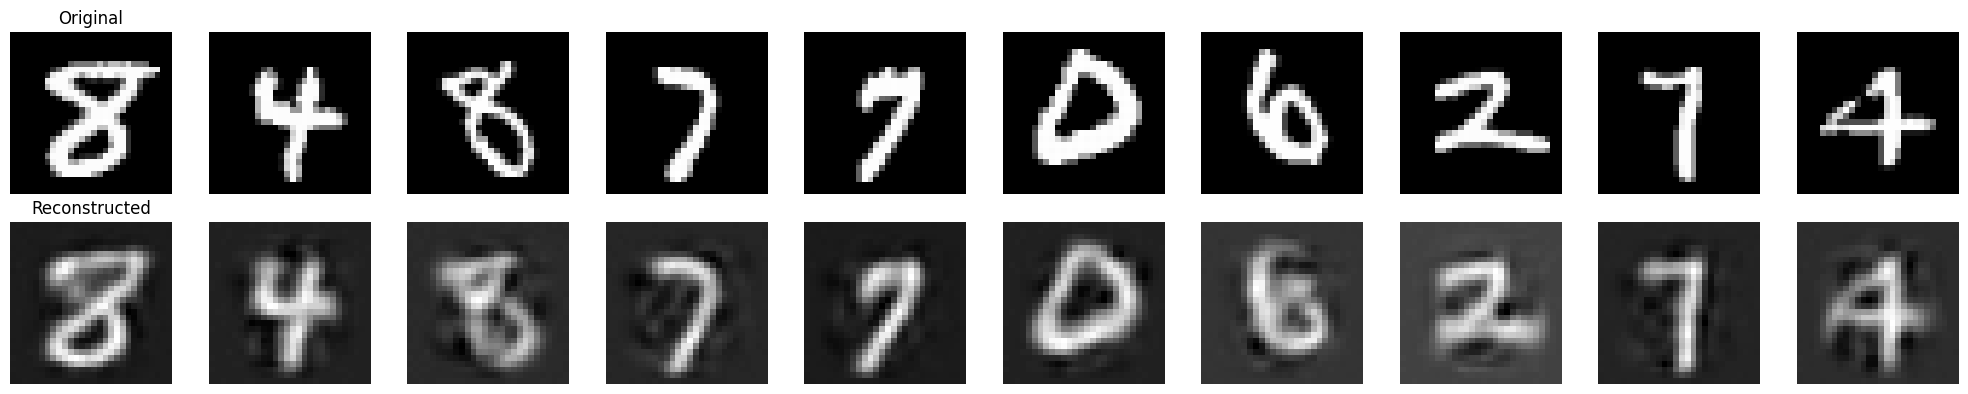

In [66]:
model.eval()

# Get some test images
test_images = X_test[:10]

# Ensure the input is in the correct shape
test_images = test_images.reshape(-1, 28 * 28)  # Flatten the images

# Reconstruct images
with torch.no_grad():
    reconstructed = model(test_images)

# Convert tensors to numpy arrays for plotting
original_images = test_images.view(-1, 28, 28).cpu().numpy()
reconstructed_images = reconstructed.view(-1, 28, 28).cpu().numpy()

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Original images
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original')
    
    # Reconstructed images
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()


In [67]:
from sklearn.manifold import TSNE
import torch

# Ensure the model is in evaluation mode
model.eval()

# Compress the entire test set using the stacked autoencoder
with torch.no_grad():
    X_test_compressed = model.encoder(X_test)

# Convert the compressed representations to numpy for t-SNE
X_test_compressed_np = X_test_compressed.cpu().numpy()

# Fit t-SNE on the compressed test data
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_compressed_np)

/tmp/ipykernel_8071/1206316633.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


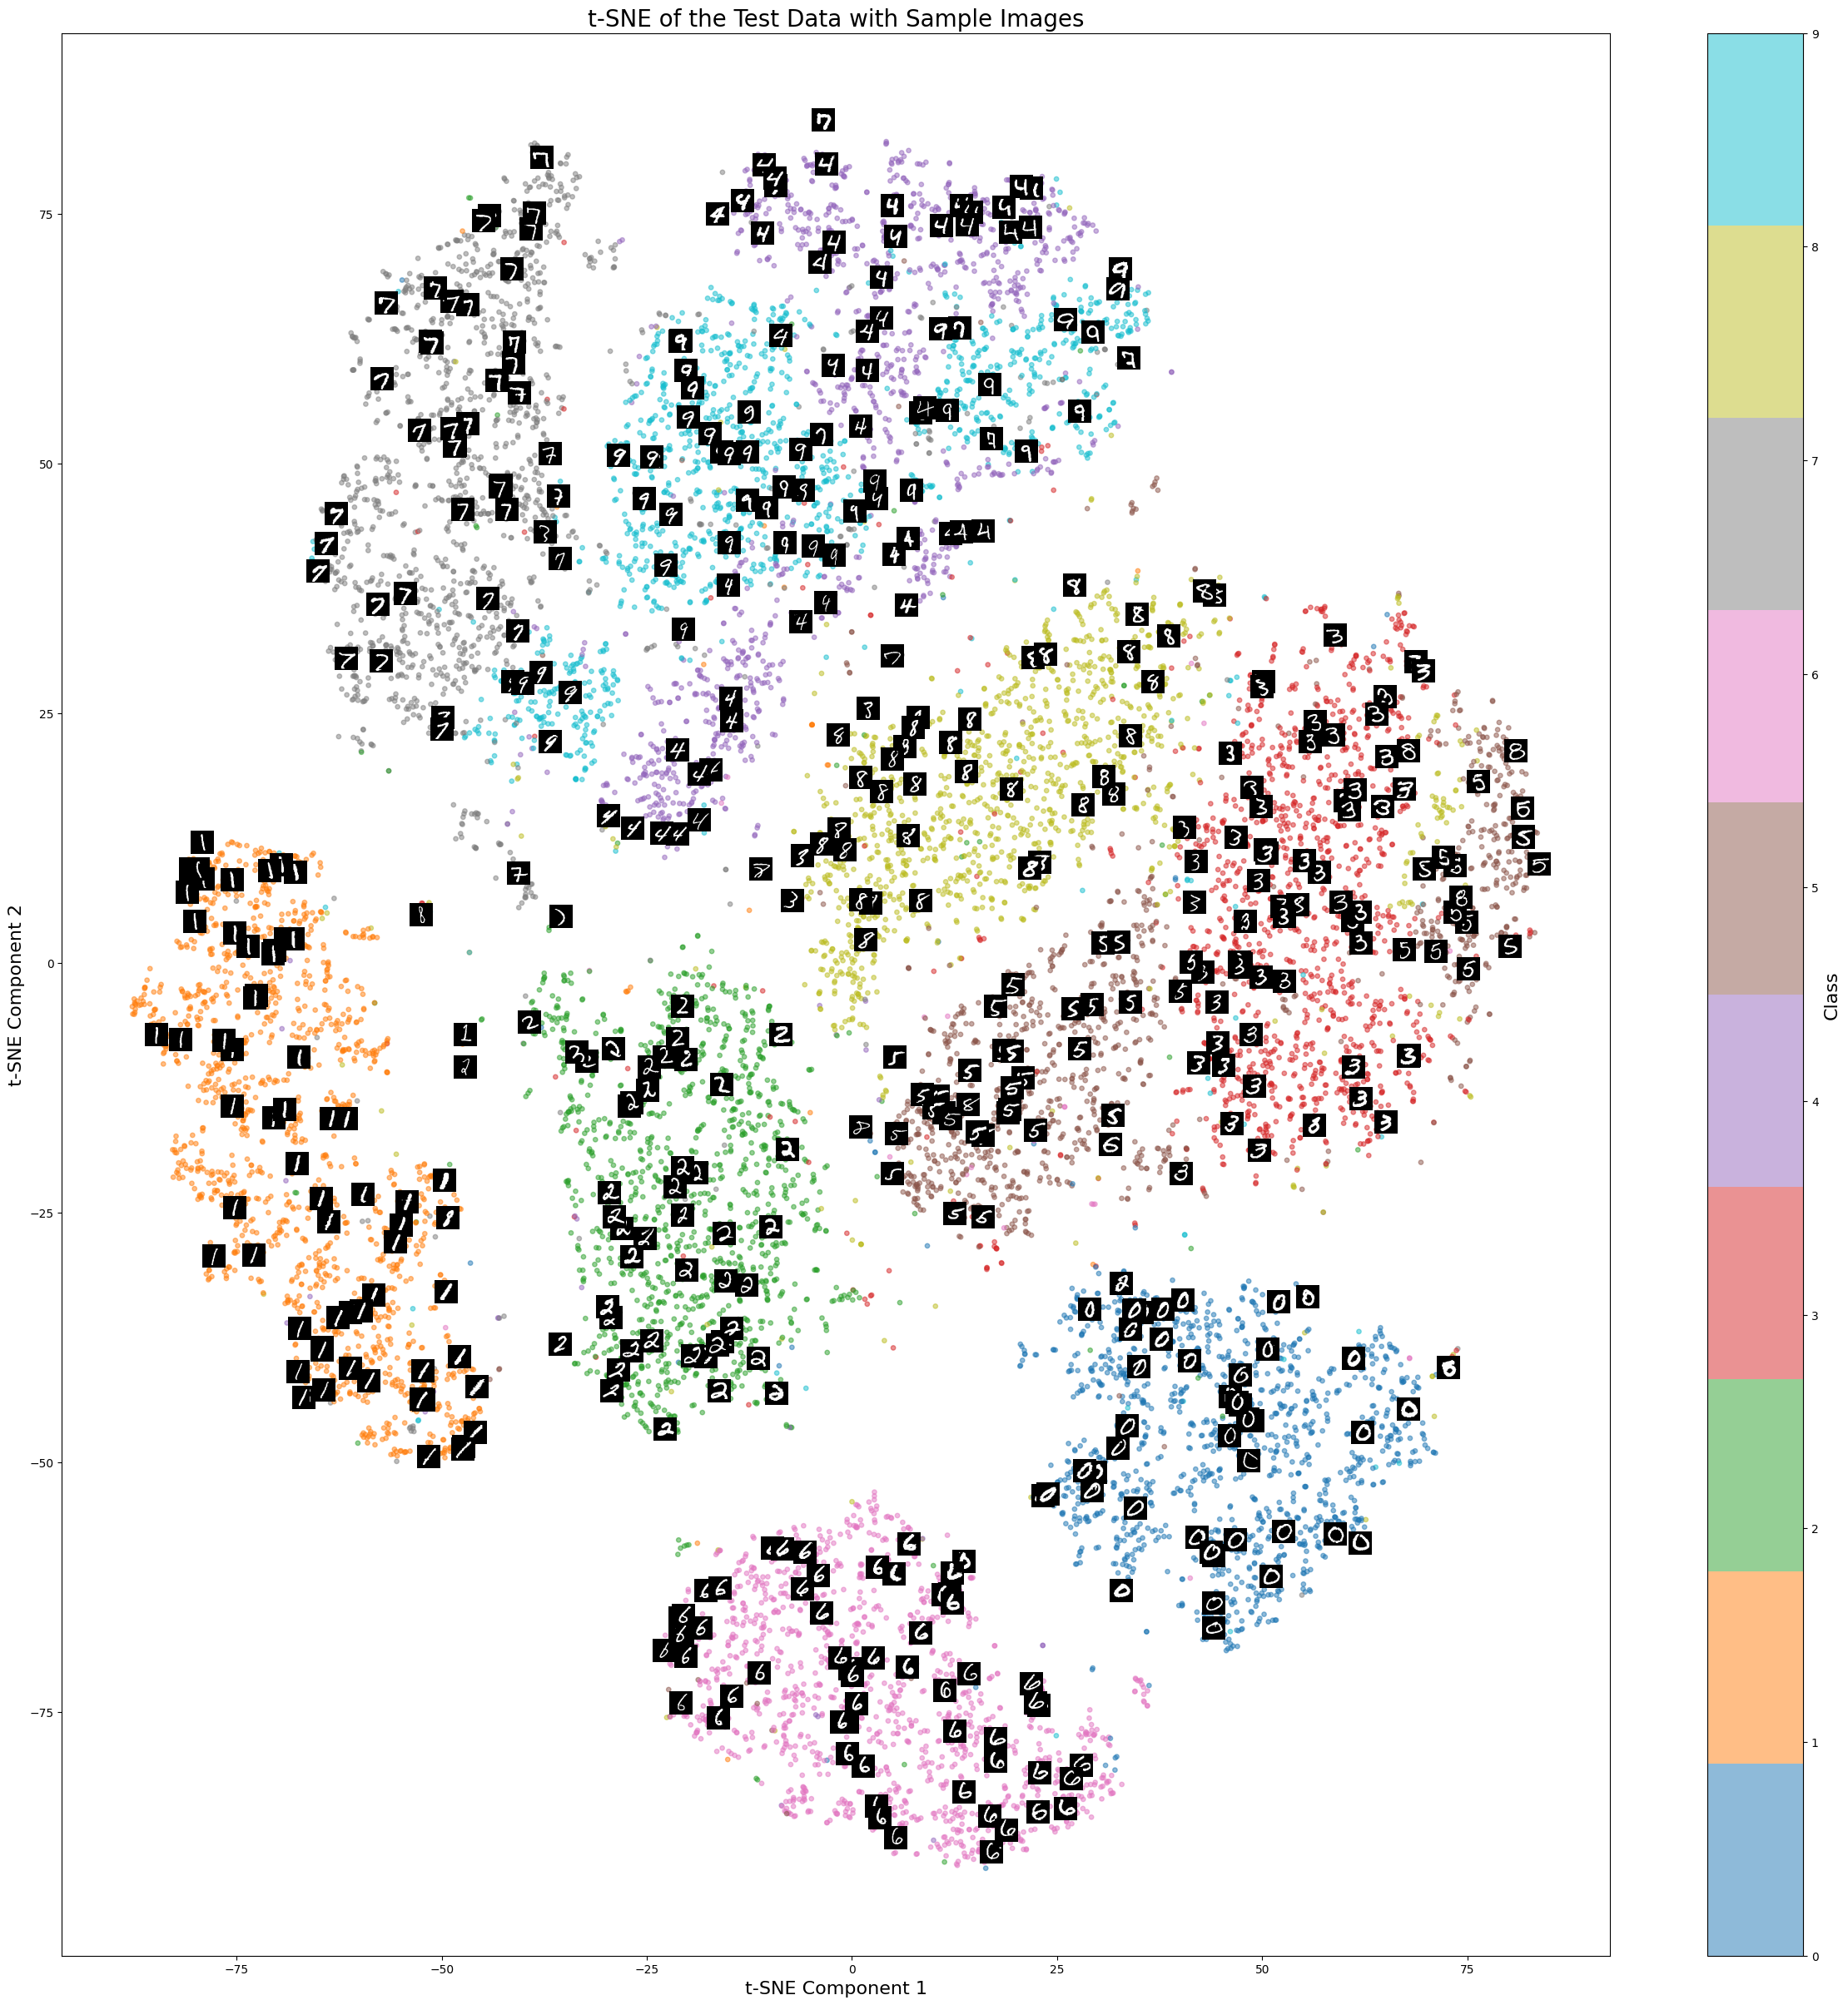

In [68]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Plot the t-SNE results with sample images
plt.figure(figsize=(30, 30))  # Increased figure size for larger overall plot

# Get the labels for the test set

# Create a colormap
cmap = plt.cm.get_cmap('tab10')

# Scatter plot of t-SNE results with colors for different classes
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap=cmap, alpha=0.5, s=15)

# Add sample images to the plot
num_samples = 500
step = len(X_test_tsne) // num_samples
for i in range(0, len(X_test_tsne), step):
    x, y = X_test_tsne[i]
    img = X_test[i].reshape(28, 28).cpu().numpy()
    img_box = OffsetImage(img, zoom=0.7, cmap='gray')
    ab = AnnotationBbox(img_box, (x, y), frameon=False, pad=0)
    plt.gca().add_artist(ab)

plt.title('t-SNE of the Test Data with Sample Images', fontsize=20)
plt.xlabel('t-SNE Component 1', fontsize=16)
plt.ylabel('t-SNE Component 2', fontsize=16)

# Add a colorbar
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Class', fontsize=16)

plt.show()


# Variational Autoencoder

In [69]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, inputs):
        mean, log_var = inputs
        eps = torch.randn_like(log_var)
        return mean + torch.exp(0.5 * log_var) * eps

codings_size = 10


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
        )
        self.fc_mean = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        self.fc_log_var = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        self.codings_fc = Sampling()
    
    def forward(self, x):
        x = self.seq(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        z = self.codings_fc((mean, log_var))
        return [mean, log_var, z]

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            # Using sigmoid to output in the range [0, 1] because we're
            # dealing with images
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.seq(z)


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mean, log_var, z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x, mean, log_var

def vae_loss(recon_x, x, mean, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_div

input_dim = 28 * 28
hidden_dim = 150
latent_dim = 10
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

VAE(
  (encoder): Encoder(
    (seq): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=150, bias=True)
      (2): ReLU()
      (3): Linear(in_features=150, out_features=150, bias=True)
      (4): ReLU()
    )
    (fc_mean): Linear(in_features=150, out_features=10, bias=True)
    (fc_log_var): Linear(in_features=150, out_features=10, bias=True)
    (codings_fc): Sampling()
  )
  (decoder): Decoder(
    (seq): Sequential(
      (0): Linear(in_features=10, out_features=150, bias=True)
      (1): ReLU()
      (2): Linear(in_features=150, out_features=150, bias=True)
      (3): ReLU()
      (4): Linear(in_features=150, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [70]:
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_batch, mean, log_var = model(x)
        loss = vae_loss(recon_batch, x, mean, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    # model.eval()
    # val_loss = 0
    # with torch.no_grad():
    #     for batch in val_loader:
    #         x = batch[0].to(device)
    #         recon_batch, mean, log_var = model(x)
    #         loss = vae_loss(recon_batch, x, mean, log_var)
    #         val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    # avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {avg_train_loss:.4f}')

    # Early stopping and model checkpointing
    # if avg_val_loss < best_val_loss:
    #     best_val_loss = avg_val_loss
    #     torch.save(model.state_dict(), 'best_model.pth')
    # elif epoch > early_stopping_patience:
    #     print("Early stopping")

Epoch [1/30], Train Loss: 3113.3522
Epoch [2/30], Train Loss: 2317.2653
Epoch [3/30], Train Loss: 2152.0799
Epoch [4/30], Train Loss: 2077.7509
Epoch [5/30], Train Loss: 2026.9620
Epoch [6/30], Train Loss: 1991.8925
Epoch [7/30], Train Loss: 1965.7594
Epoch [8/30], Train Loss: 1946.5003
Epoch [9/30], Train Loss: 1929.1911
Epoch [10/30], Train Loss: 1917.7233
Epoch [11/30], Train Loss: 1906.1160
Epoch [12/30], Train Loss: 1897.2692
Epoch [13/30], Train Loss: 1887.2590
Epoch [14/30], Train Loss: 1879.9661
Epoch [15/30], Train Loss: 1874.6810
Epoch [16/30], Train Loss: 1867.3663
Epoch [17/30], Train Loss: 1864.8636
Epoch [18/30], Train Loss: 1856.8507
Epoch [19/30], Train Loss: 1854.0416
Epoch [20/30], Train Loss: 1849.3891
Epoch [21/30], Train Loss: 1844.7744
Epoch [22/30], Train Loss: 1842.6592
Epoch [23/30], Train Loss: 1838.4085
Epoch [24/30], Train Loss: 1835.4981
Epoch [25/30], Train Loss: 1832.4558
Epoch [26/30], Train Loss: 1831.1263
Epoch [27/30], Train Loss: 1828.8940
Epoch [28/

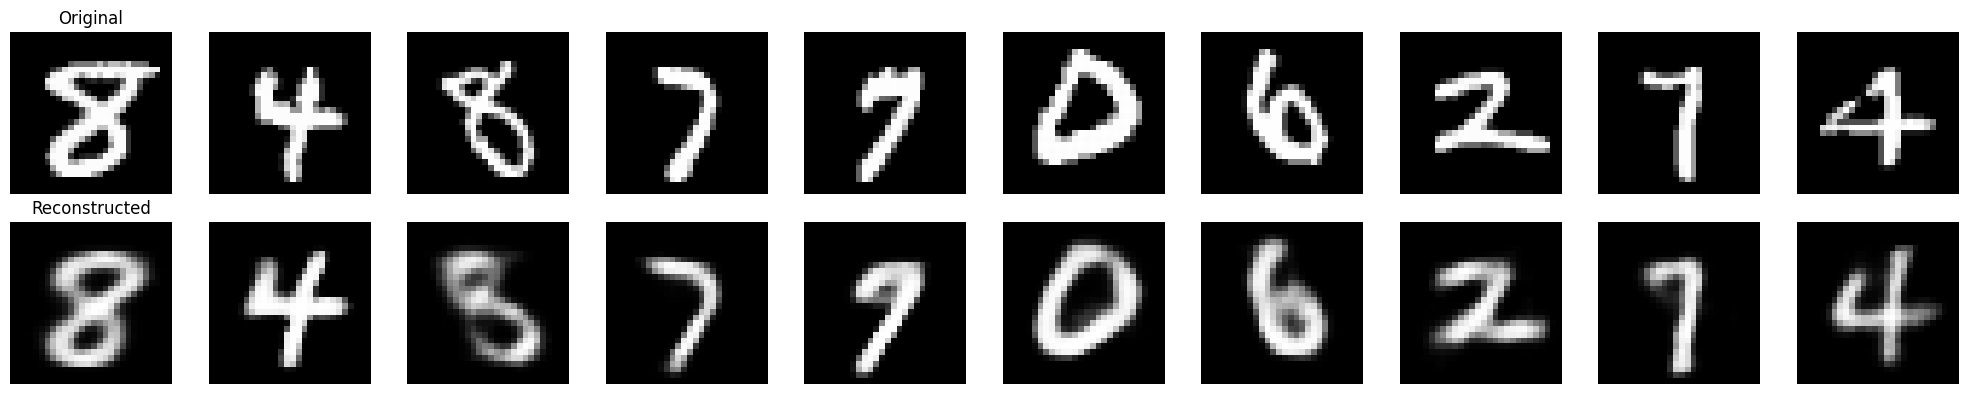

In [71]:
# Set the model to evaluation mode
model.eval()

# Get a batch of test images
test_batch = next(iter(test_loader))
test_images = test_batch[0].to(device)

# Generate reconstructions
with torch.no_grad():
    reconstructions, _, _ = model(test_images)

# Move tensors to CPU and convert to numpy arrays
test_images = test_images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

# Create a figure to display original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Display original image
    axes[0, i].imshow(test_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original')
    
    # Display reconstructed image
    axes[1, i].imshow(reconstructions[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()
